# Metropolis Algorithm

In [9]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from math import sqrt, exp, log
import seaborn as sbn

## Spin

### Distribution

We write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
We compute the energy $H(\sigma)$ of the spin configuration.

Then we write a function that accepts an integer $n$ and returns a random spin configuration for an $n \times n$ lattice (as an $n \times n$ NumPy array of $1$s and $-1$s).
We show our function output with $n = 100$, plotting the spin configuration via `pyplot`.

In [10]:
def proposal(x,s):
    """The proposal function Q(x,y) = N(x|y,sI)."""
    return stats.multivariate_normal.rvs(mean=x, cov=s*np.eye(len(x)))

In [11]:
def propLogDensity(x):
    """Calculate the log of the proportional density."""
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=sqrt(x[1])).sum()
    return logprob    # ^this is where the scores are used.

In [12]:
def acceptance(x, y):
    return min(0, propLogDensity(x) - propLogDensity(y))

In [13]:
def metropolis(y0, s, n_samples):
    """Use the Metropolis algorithm to sample from posterior.
    Parameters:
     x0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
     s (float): The standard deviation parameter for the proposal function.
     n_samples (int): The number of samples to generate.
   
   Returns:
     draws ((n_samples, 2) ndarray): The MCMC samples.
     logprobs ((n_samples,) ndarray): The log density of the samples.
     accept_rate (float): The proportion of accepted proposed samples."""
    accept_counter = 0
    draws = np.empty((n_samples,2))
    logprob = np.empty(n_samples)
    x = x0.copy()
    for i in range(n_samples):
        xprime = proposal(x,s)
        a = np.random.uniform()
        if log(a) <= acceptance(xprime, x):
            accept_counter += 1
            x = xprime
        draws[i] = x
        logprob[i] = propLogDensity(x)
    return draws, logprob, accept_counter/n_samples

### Actual sampling



In [14]:
def random_lattice(n=100):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n,n))
    for k in range(n):
        random_spin[k,:] = 2*np.random.binomial(1,.5, n) -1
    return random_spin

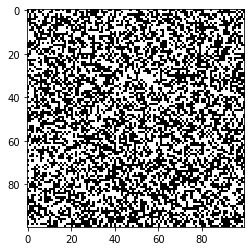

In [27]:
# Display a random spin lattice generated by random_lattice()
lattice = random_lattice(100)
plt.imshow(lattice,cmap="gray")
plt.show()

In [16]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    """
    return -np.sum(L*np.roll(L,1,axis=0) + L*np.roll(L,1,axis=1))

## Flip the spin randomly

We write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair has equal probability $\frac{1}{n^2}$ of being chosen.

In [17]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1."""
    return tuple(np.random.randint(n,size=2))   

### Compute new energy after spin flip

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [22]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    """
    n = len(L)
    return L_energy + 2*L[i,j]*(L[(i+1)%n,j] + L[i-1,j] + L[i,(j+1)%n] + L[i,j-1])

## Accept or reject using acceptance probability

We write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$, then calculate whether or not the new spin configuration $\sigma^*$ should be accepted (returning `True` or `False`).

In [19]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration."""
    # Recall that acceptance prob'ty A(σ*, σ) = { 1 if H(σ*) < H(σ)
    #                                           { e^(β*(H(σ)-H(σ*))) otherwise
    if energy_new < energy_old:
        return True
    else:
        prob = np.exp(beta*(energy_old-energy_new))
        # sample from Unif(0,1) and test if the output is below the prob'ty threshold
        samp = np.random.uniform()
        if samp <= prob:
            return True
        else:
            return False

## Metropolis

Below is a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
First it initializes an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Then we use the Metropolis algorithm to (potentially) update the lattice `burn_in` times in the following way:
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, the function continues the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
It returns the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.



In [20]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    L = random_lattice(n)
    L_energy = lattice_energy(L)
    weighted_energies = []
    saved_samples = []
    num_accepted = 0
    for i in range(burn_in):
        i, j = flip_location(n)
        energy_new = updated_energy(L, L_energy, i, j)
        if accept(beta,energy_old=L_energy,energy_new=energy_new):
            L[i,j] = -L[i,j]
            L_energy = energy_new
#             num_accepted += 1
        weighted_energies.append(-beta*L_energy)
        
    for i in range(n_samples):
        i, j = flip_location(n)
        energy_new = updated_energy(L, L_energy, i, j)
        if accept(beta,energy_old=L_energy,energy_new=energy_new):
            L[i,j] = -L[i,j]
            L_energy = energy_new
            num_accepted += 1
        weighted_energies.append(-beta*L_energy)
        if i % 100 == 0:
            saved_samples.append(L)
            
    return np.array(saved_samples), np.array(weighted_energies), num_accepted/n_samples

### Metropolis in action: displayed examples

We test our sampler on a $100 \times 100$ grid with $200000$ total iterations, for $\beta = 0.2, 0.4, 1$.
Below plotted are the proportional log probabilities, as well as a late sample from each test.

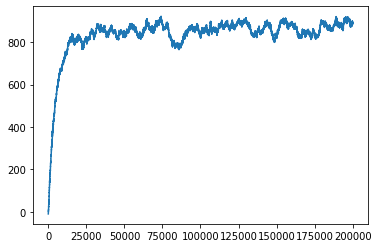

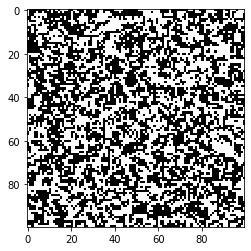

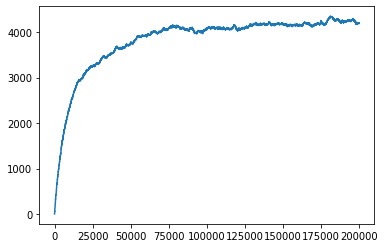

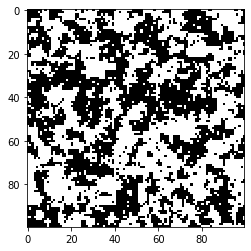

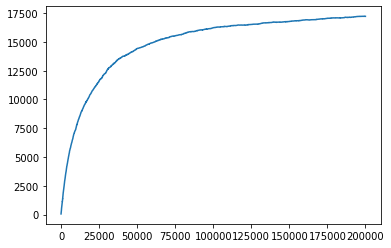

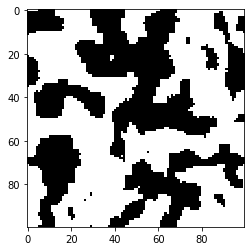

In [23]:
for β in [.2,.4,1.]:
    saved_samples, weighted_energies, acceptance_rate = ising_metropolis(β)
    last_L = saved_samples[-1]
    plt.plot(weighted_energies)
    plt.show()
    plt.imshow(last_L,cmap="gray")
    plt.show()